#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from sklearn import tree

from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

import time


#from graphviz import Source

#### parameters to set

In [2]:
n_series = 6
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
cut = 0.55
window = 24

#### generate normal data

In [3]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['auc_score']=0.5
df.index = dti
df.head()

,link 0,link 1,link 2,link 3,link 4,link 5,Flag,auc_score
2017-08-01 00:00:00,0.268755,0.364798,0.369868,0.414560,0.385454,0.050676,0,0.5
2017-08-01 00:00:01,0.247535,0.359879,0.417674,0.408745,0.395546,0.061284,0,0.5
2017-08-01 00:00:02,0.256308,0.490259,0.398376,0.410857,0.390181,0.058360,0,0.5
2017-08-01 00:00:03,0.239375,0.416303,0.446528,0.422528,0.377537,0.049185,0,0.5
2017-08-01 00:00:04,0.242504,0.369565,0.390247,0.422522,0.401551,0.041097,0,0.5


#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = int(n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
    for s in affects:
        df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
    df.iloc[start:end,n_series]=1
        

affected: [4, 5, 2, 1, 3, 0] 2017-08-04 12:21:14 2017-08-04 14:51:17
affected: [5, 3, 4, 2, 1] 2017-08-07 11:50:07 2017-08-07 14:10:57
affected: [5, 1, 4] 2017-08-06 22:14:16 2017-08-07 00:47:22
affected: [2, 5, 4, 0, 1, 3] 2017-08-05 23:20:05 2017-08-05 23:44:12
affected: [2, 1, 4, 5, 0, 3] 2017-08-03 23:19:53 2017-08-04 02:16:38
affected: [2, 0, 3, 1, 4, 5] 2017-08-01 20:03:34 2017-08-01 20:52:42


#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

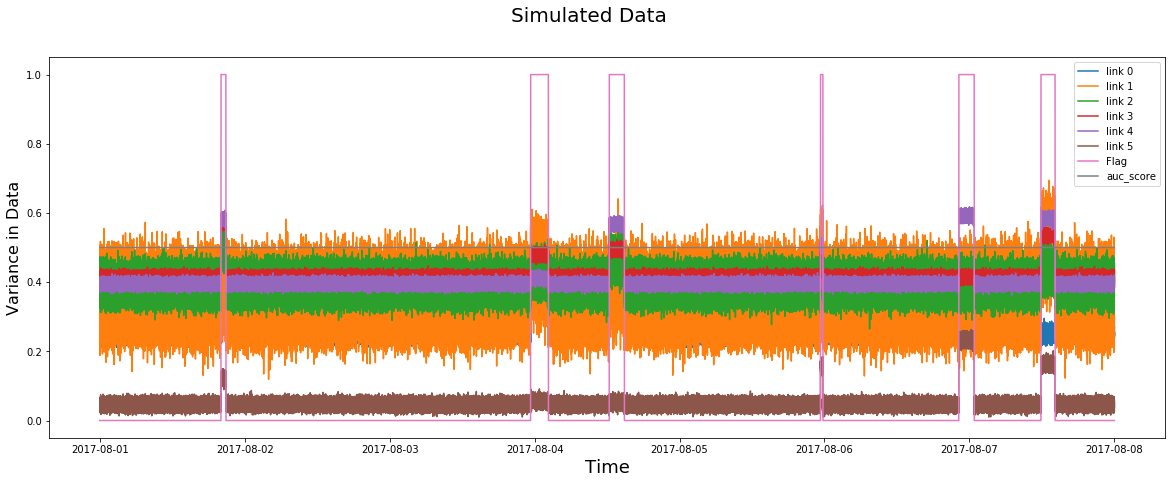

In [6]:
#df.plot(figsize=(20,7))
fig = plt.figure(figsize=(20,7))
plt.plot(df)
fig.suptitle('Simulated Data', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variance in Data', fontsize=16)
plt.legend(df)

In [7]:
#plt.figure(figsize=[16, 17])
#gs = gridspec.GridSpec(4, 1)

#ax2.plot(df)
#ax2.set_xlabel('time')
#ax2.set_ylabel('variance in data')
#ax2.legend()

#plt.show()

In [8]:
print(df['auc_score'])

2017-08-01 00:00:00    0.5
2017-08-01 00:00:01    0.5
2017-08-01 00:00:02    0.5
2017-08-01 00:00:03    0.5
2017-08-01 00:00:04    0.5
2017-08-01 00:00:05    0.5
2017-08-01 00:00:06    0.5
2017-08-01 00:00:07    0.5
2017-08-01 00:00:08    0.5
2017-08-01 00:00:09    0.5
2017-08-01 00:00:10    0.5
2017-08-01 00:00:11    0.5
2017-08-01 00:00:12    0.5
2017-08-01 00:00:13    0.5
2017-08-01 00:00:14    0.5
2017-08-01 00:00:15    0.5
2017-08-01 00:00:16    0.5
2017-08-01 00:00:17    0.5
2017-08-01 00:00:18    0.5
2017-08-01 00:00:19    0.5
2017-08-01 00:00:20    0.5
2017-08-01 00:00:21    0.5
2017-08-01 00:00:22    0.5
2017-08-01 00:00:23    0.5
2017-08-01 00:00:24    0.5
2017-08-01 00:00:25    0.5
2017-08-01 00:00:26    0.5
2017-08-01 00:00:27    0.5
2017-08-01 00:00:28    0.5
2017-08-01 00:00:29    0.5
                      ... 
2017-08-07 23:59:30    0.5
2017-08-07 23:59:31    0.5
2017-08-07 23:59:32    0.5
2017-08-07 23:59:33    0.5
2017-08-07 23:59:34    0.5
2017-08-07 23:59:35    0.5
2

In [9]:
print(df)

                       link 0    link 1    link 2    link 3    link 4  \
2017-08-01 00:00:00  0.268755  0.364798  0.369868  0.414560  0.385454   
2017-08-01 00:00:01  0.247535  0.359879  0.417674  0.408745  0.395546   
2017-08-01 00:00:02  0.256308  0.490259  0.398376  0.410857  0.390181   
2017-08-01 00:00:03  0.239375  0.416303  0.446528  0.422528  0.377537   
2017-08-01 00:00:04  0.242504  0.369565  0.390247  0.422522  0.401551   
2017-08-01 00:00:05  0.236949  0.371219  0.395646  0.409502  0.401982   
2017-08-01 00:00:06  0.258176  0.350449  0.400488  0.415457  0.397984   
2017-08-01 00:00:07  0.270674  0.300301  0.372324  0.419026  0.394377   
2017-08-01 00:00:08  0.250043  0.341318  0.404140  0.419059  0.392955   
2017-08-01 00:00:09  0.257513  0.379147  0.371166  0.411886  0.405303   
2017-08-01 00:00:10  0.249702  0.394868  0.363974  0.422975  0.395738   
2017-08-01 00:00:11  0.231284  0.389748  0.406827  0.430697  0.392422   
2017-08-01 00:00:12  0.248009  0.348138  0.405423  

#### functions

In [10]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    #print("y_ref before: ", y_ref)
    #print("x_ref before: ", x_ref)
    del X_ref['Flag']
    del X_ref['auc_score']
    #print("x_ref after: ", X_ref)
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    #print("y_sub before: ", y_sub)
    #print("x_sub before: ", X_sub)
    del X_sub['Flag']
    del X_sub['auc_score']
    #print("X_sub after: ", X_sub)
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6)) #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
        plot_roc(fpr, tpr, auc_score)
        #filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        #tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        #tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [11]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
start = df.index.min()
end = df.index.max()

#print(df)

print(df.index)

DatetimeIndex(['2017-08-01 00:00:00', '2017-08-01 00:00:01',
               '2017-08-01 00:00:02', '2017-08-01 00:00:03',
               '2017-08-01 00:00:04', '2017-08-01 00:00:05',
               '2017-08-01 00:00:06', '2017-08-01 00:00:07',
               '2017-08-01 00:00:08', '2017-08-01 00:00:09',
               ...
               '2017-08-07 23:59:50', '2017-08-07 23:59:51',
               '2017-08-07 23:59:52', '2017-08-07 23:59:53',
               '2017-08-07 23:59:54', '2017-08-07 23:59:55',
               '2017-08-07 23:59:56', '2017-08-07 23:59:57',
               '2017-08-07 23:59:58', '2017-08-07 23:59:59'],
              dtype='datetime64[ns]', length=604800, freq='S')


#### Looping over time intervals

auc_score =  0.503800154321 	feature importances: [ 0.17827156  0.16338534  0.13955952  0.15168525  0.18319203  0.1839063 ]
auc_score =  0.499633487654 	feature importances: [ 0.17857351  0.16215183  0.14739189  0.16517212  0.16560846  0.18110218]
auc_score =  0.502160493827 	feature importances: [ 0.19754561  0.15551611  0.17087316  0.17767637  0.13405354  0.16433521]
auc_score =  0.501080246914 	feature importances: [ 0.13804445  0.16787266  0.17800187  0.18240268  0.16002123  0.17365711]
auc_score =  0.499768518519 	feature importances: [ 0.17164976  0.18009936  0.18314998  0.16007848  0.14658079  0.15844162]
auc_score =  0.500077160494 	feature importances: [ 0.17689983  0.16163532  0.18842348  0.13897275  0.16226482  0.1718038 ]
auc_score =  0.501138117284 	feature importances: [ 0.15095324  0.18378875  0.17126752  0.17915376  0.16941233  0.1454244 ]
auc_score =  0.50111882716 	feature importances: [ 0.17568648  0.13944667  0.15440123  0.17453183  0.16337538  0.19255841]
auc_score

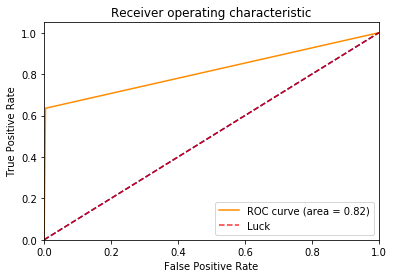

auc_score =  0.801851851852 	feature importances: [ 0.16121388  0.1459784   0.1703628   0.18959164  0.17219152  0.16066176]


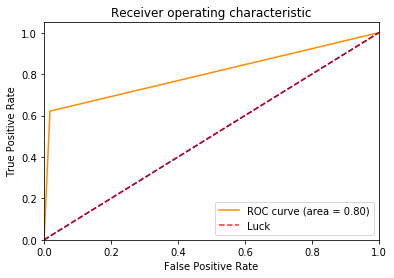

auc_score =  0.644791666667 	feature importances: [ 0.15529043  0.14562087  0.15421486  0.19109297  0.17722983  0.17655104]


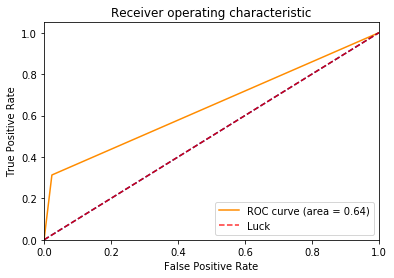

auc_score =  0.502199074074 	feature importances: [ 0.14296094  0.18093663  0.17999691  0.16470276  0.15354326  0.1778595 ]
auc_score =  0.50256558642 	feature importances: [ 0.17958477  0.15234629  0.14313095  0.16716959  0.18672516  0.17104324]
auc_score =  0.502334104938 	feature importances: [ 0.18263187  0.15031366  0.18715623  0.1522016   0.16870855  0.15898809]
auc_score =  0.50044367284 	feature importances: [ 0.18107189  0.16596662  0.1616267   0.17328726  0.16354856  0.15449898]
auc_score =  0.499093364198 	feature importances: [ 0.1789575   0.16732893  0.15371432  0.16118959  0.1684402   0.17036947]
auc_score =  0.501022376543 	feature importances: [ 0.16569413  0.16038948  0.15249748  0.18675974  0.18488942  0.14976976]
auc_score =  0.504089506173 	feature importances: [ 0.15837527  0.15713069  0.16775775  0.17806626  0.1899187   0.14875134]
auc_score =  0.499459876543 	feature importances: [ 0.19988644  0.15800587  0.14803875  0.17094975  0.15808672  0.16503247]
auc_score 

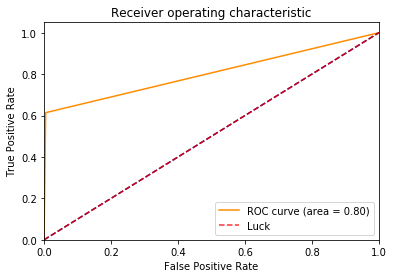

auc_score =  0.813445216049 	feature importances: [ 0.16021109  0.16544805  0.18140865  0.15811339  0.16725099  0.16756782]


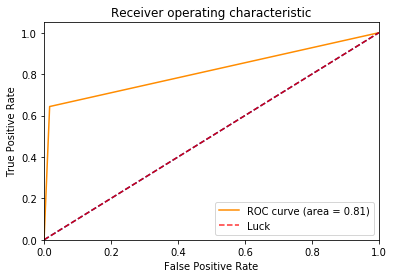

auc_score =  0.576215277778 	feature importances: [ 0.16614264  0.16598938  0.16797217  0.17360326  0.17272847  0.15356408]


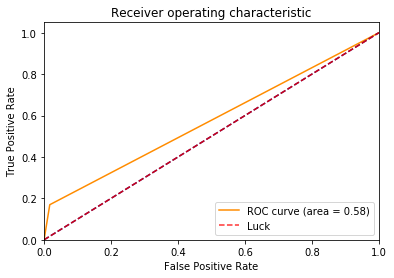

auc_score =  0.501948302469 	feature importances: [ 0.13950611  0.16666426  0.16527995  0.19542776  0.18383803  0.14928389]
auc_score =  0.499710648148 	feature importances: [ 0.16236643  0.16969274  0.15712457  0.19124529  0.15183485  0.16773612]
auc_score =  0.503337191358 	feature importances: [ 0.18164928  0.17070949  0.17555385  0.14046494  0.164108    0.16751444]
auc_score =  0.502334104938 	feature importances: [ 0.1863464   0.19206618  0.1467411   0.14103383  0.14035376  0.19345874]
auc_score =  0.503858024691 	feature importances: [ 0.1667359   0.17236015  0.15350774  0.15716184  0.18859401  0.16164037]
auc_score =  0.499864969136 	feature importances: [ 0.16072241  0.15608178  0.15228039  0.16802196  0.17608439  0.18680907]
auc_score =  0.503452932099 	feature importances: [ 0.17104499  0.16762583  0.15774308  0.1813986   0.16276901  0.15941849]
auc_score =  0.501871141975 	feature importances: [ 0.19454272  0.15034267  0.16354347  0.16991811  0.15050847  0.17114455]
auc_scor

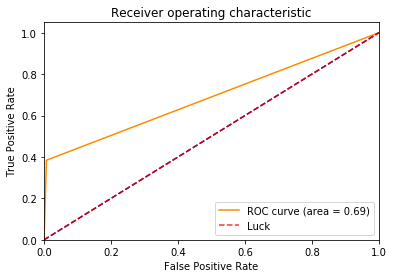

auc_score =  0.498591820988 	feature importances: [ 0.15369708  0.14896289  0.19051028  0.18164366  0.16986699  0.1553191 ]
auc_score =  0.50412808642 	feature importances: [ 0.15009894  0.16861512  0.1708204   0.16635906  0.16759727  0.17650921]
auc_score =  0.501369598765 	feature importances: [ 0.1832444   0.1524221   0.16669961  0.17065682  0.15475185  0.17222522]
auc_score =  0.497550154321 	feature importances: [ 0.17269549  0.14381179  0.16558288  0.21483092  0.15419346  0.14888546]
auc_score =  0.500173611111 	feature importances: [ 0.15200157  0.17918082  0.15177766  0.15968309  0.17912389  0.17823296]
auc_score =  0.499922839506 	feature importances: [ 0.16075202  0.17563315  0.18255199  0.15692195  0.15778727  0.16635363]
auc_score =  0.502314814815 	feature importances: [ 0.17554728  0.16088092  0.16090018  0.15508894  0.15069398  0.1968887 ]
auc_score =  0.499710648148 	feature importances: [ 0.14930289  0.15649866  0.16298777  0.19064773  0.17836007  0.16220288]
auc_score

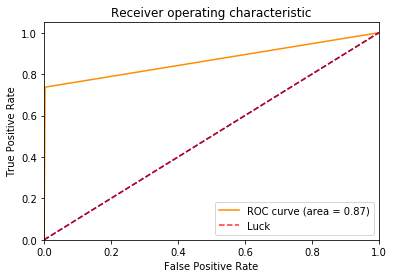

auc_score =  0.774131944444 	feature importances: [ 0.15135033  0.17131369  0.14297196  0.17800766  0.1880748   0.16828156]


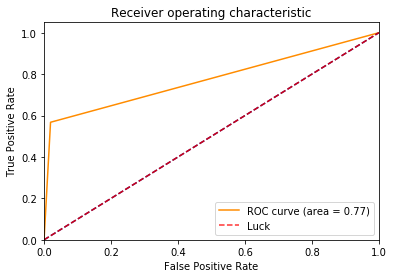

auc_score =  0.573263888889 	feature importances: [ 0.15062827  0.14715171  0.14746336  0.14116962  0.18699504  0.226592  ]


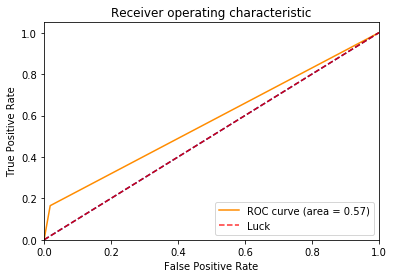

auc_score =  0.499884259259 	feature importances: [ 0.16620327  0.15272464  0.17203671  0.17911075  0.16342107  0.16650356]
auc_score =  0.500713734568 	feature importances: [ 0.1389084   0.17173884  0.17163214  0.16079019  0.17076282  0.18616762]
auc_score =  0.497704475309 	feature importances: [ 0.1518709   0.14920023  0.16042271  0.16478476  0.19778382  0.17593757]
auc_score =  0.499189814815 	feature importances: [ 0.16668449  0.14087353  0.17508059  0.1712242   0.16999071  0.17614648]
auc_score =  0.501195987654 	feature importances: [ 0.14132804  0.15909454  0.19581322  0.15079784  0.17770378  0.17526258]
auc_score =  0.501292438272 	feature importances: [ 0.16401128  0.16682572  0.15143001  0.1691391   0.18874382  0.15985007]
auc_score =  0.498013117284 	feature importances: [ 0.16287958  0.15033399  0.19101155  0.16502405  0.15077641  0.17997441]
auc_score =  0.49899691358 	feature importances: [ 0.17204989  0.14305248  0.16097407  0.18429558  0.15017897  0.18944901]
auc_score

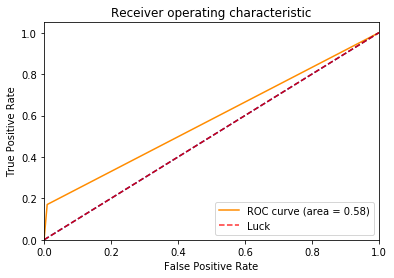

auc_score =  0.968287037037 	feature importances: [ 0.16851864  0.16448714  0.1649511   0.19773605  0.16308324  0.14122383]


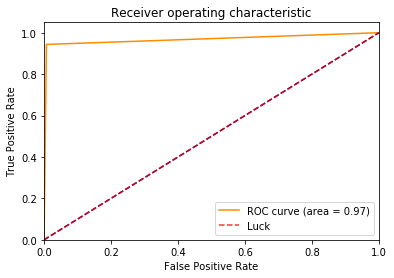

auc_score =  0.706616512346 	feature importances: [ 0.1388955   0.16566905  0.16406182  0.18549202  0.17297447  0.17290714]


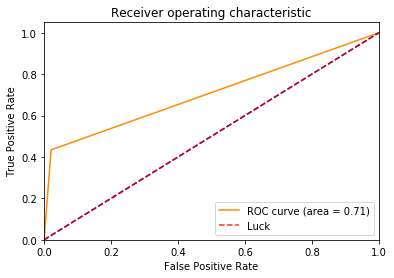

auc_score =  0.499382716049 	feature importances: [ 0.16125201  0.17342623  0.18608577  0.16934777  0.15663718  0.15325104]
auc_score =  0.501793981481 	feature importances: [ 0.14649663  0.16020517  0.1758727   0.19875128  0.17197532  0.1466989 ]
auc_score =  0.502199074074 	feature importances: [ 0.1808723   0.15958254  0.15457006  0.16447583  0.19836122  0.14213806]
auc_score =  0.499402006173 	feature importances: [ 0.16622599  0.14839733  0.16995914  0.17507935  0.17488167  0.16545652]
auc_score =  0.503722993827 	feature importances: [ 0.14744877  0.17843306  0.16308653  0.16126624  0.17238172  0.17738369]
auc_score =  0.501466049383 	feature importances: [ 0.16039686  0.17991119  0.16228519  0.15960875  0.17850532  0.15929269]
auc_score =  0.501601080247 	feature importances: [ 0.1601442   0.1678952   0.156579    0.17439863  0.17039083  0.17059213]
auc_score =  0.504861111111 	feature importances: [ 0.14074973  0.17456059  0.15380804  0.15568716  0.1938596   0.18133489]
auc_scor

In [13]:
start_time = time.time()

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    #print("In while loop: ref_df: ", ref_df)
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    #print("In while loop: sub_df: ", sub_df)
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    #print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


In [14]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2402.936108827591 seconds ---


In [15]:
print(start)
print(end)

2017-08-01 00:00:00
2017-08-07 23:59:59


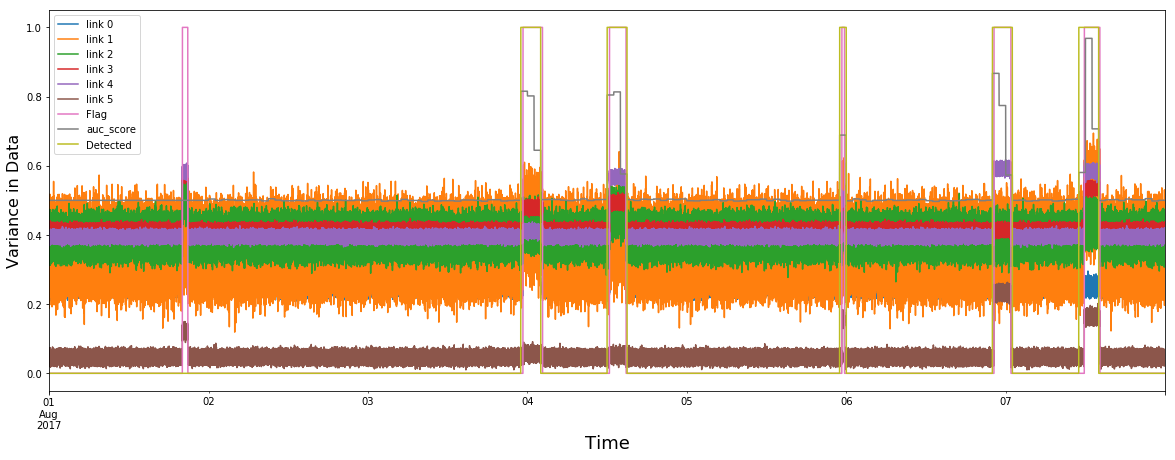

In [18]:
#df.plot(figsize=(20,7))

df.plot(figsize=(20,7))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variance in Data', fontsize=16)
plt.legend(df)

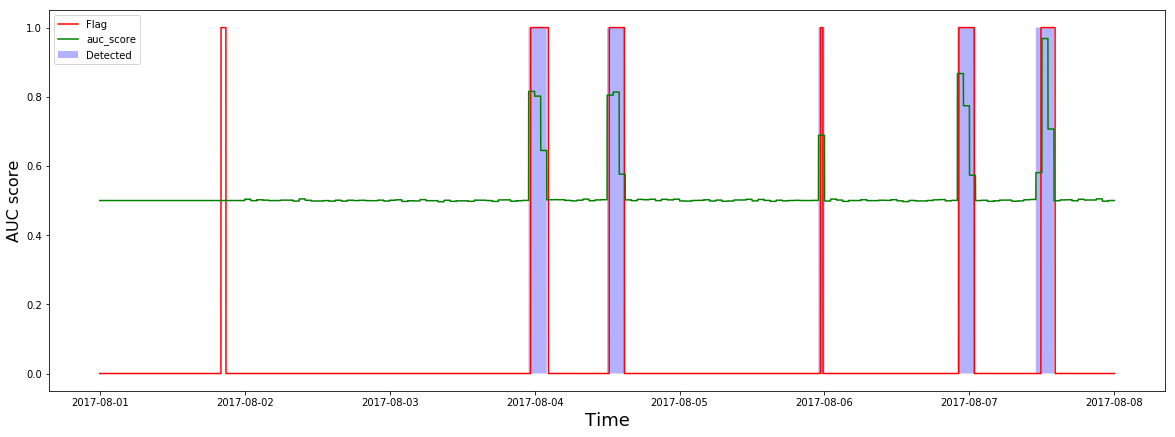

In [22]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('AUC score', fontsize=16)
plt.show()